In [1]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least) #
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
from datetime import datetime as dt
import xarray as xr

In [3]:
def prcrng(x):
    return (np.nanpercentile(x,84) - np.nanpercentile(x,16))/2.

In [4]:
dir_acs = "/users/rsg/spa/spapapers/Pardo_Globlal_Chla/insitu/reprocessing/netCDF/Graban2020/"
fn_acs = "NAAMES1.nc"

In [5]:
# read ACS (and HPLC) data in xr format
acs = xr.open_dataset(dir_acs + fn_acs)

# check keys
print(acs.keys())

#check attributes
acs['acs_chl'].attrs

# no of samples
print('No. of HPLC samples= ' + str(len(acs.hplc_time)))
print('No of ACS samples= ' + str(len(acs.time)))

KeysView(<xarray.Dataset>
Dimensions:         (time: 15189, hplc_time: 48, acs_wv: 176)
Coordinates:
  * time            (time) datetime64[ns] 2015-11-06T20:11:00 ... 2015-11-30T...
  * hplc_time       (hplc_time) datetime64[ns] 2015-11-06T02:09:00 ... 2015-1...
  * acs_wv          (acs_wv) float64 400.0 402.0 404.0 ... 746.0 748.0 750.0
Data variables:
    hplc_lat        (hplc_time) float64 ...
    hplc_lon        (hplc_time) float64 ...
    hplc_Tot_Chl_a  (hplc_time) float64 ...
    uway_lat        (time) float64 ...
    uway_lon        (time) float64 ...
    acs_chl         (time) float64 ...
    acs_ap          (time, acs_wv) float64 ...)
No. of HPLC samples= 48
No of ACS samples= 15189


['2015-11-06T20:11:00.000000000' '2015-11-06T20:12:00.000000000'
 '2015-11-06T20:13:00.000000000' ... '2015-11-30T15:58:00.000000000'
 '2015-11-30T15:59:00.000000000' '2015-11-30T16:00:00.000000000']


Text(0, 0.5, 'lon')

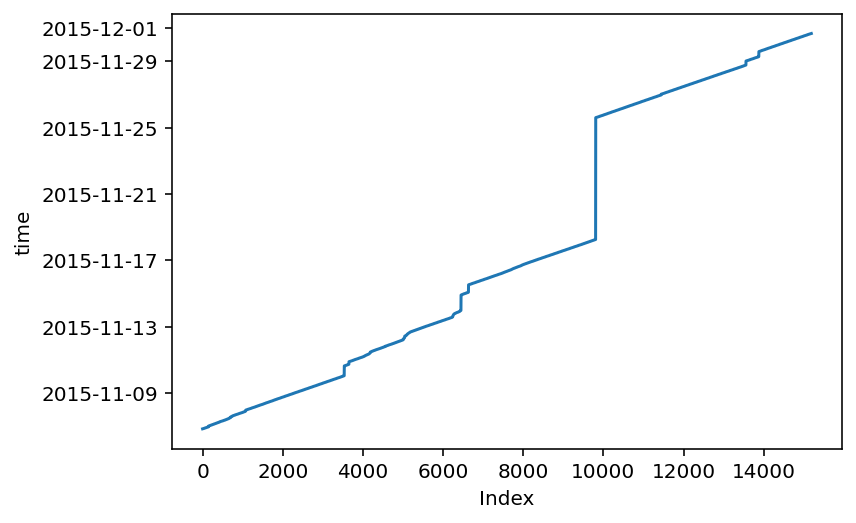

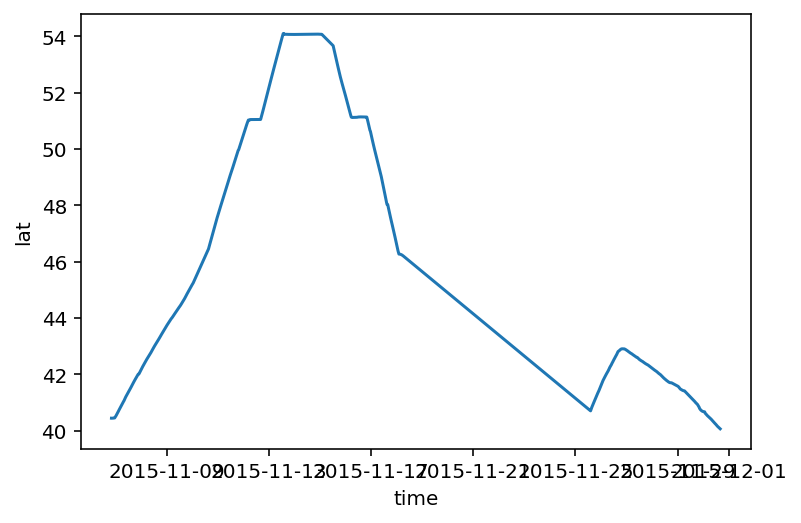

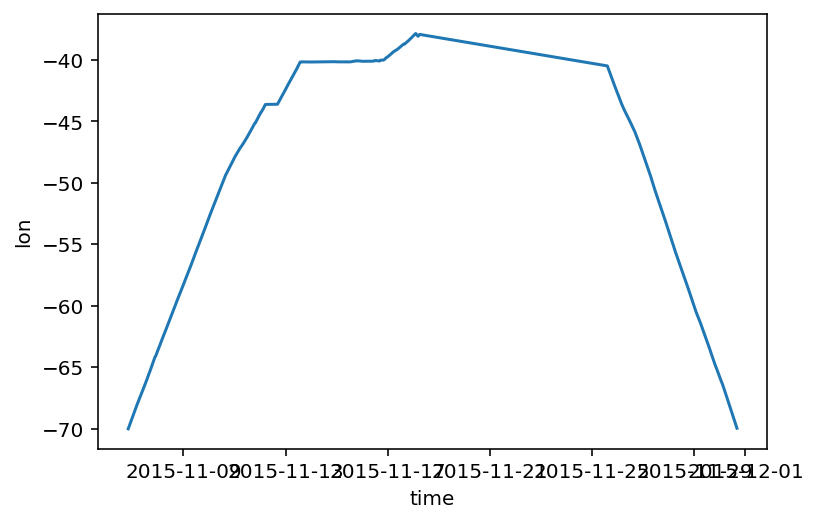

In [6]:
# check time, lat, lon
plt.rcParams.update({'font.size': 9})
    
plt.figure()
plt.plot(acs.time)
plt.xlabel('Index')
plt.ylabel('time')
print(acs.time.values)


plt.figure()
plt.plot(acs.time,acs.uway_lat)
plt.xlabel('time')
plt.ylabel('lat')

plt.figure()
plt.plot(acs.time,acs.uway_lon)
plt.xlabel('time')
plt.ylabel('lon')



In [7]:
# check temporal sample rate
plt.figure()
delta_t = np.median(np.diff(acs.time))
print(delta_t)
print(str(int(delta_t/10**9)) + ' secs')

# == 1 min sample rate for NAAMES1

60000000000 nanoseconds
60 secs


<Figure size 432x288 with 0 Axes>

['hplc_lat', 'hplc_lon', 'hplc_Tot_Chl_a', 'uway_lat', 'uway_lon', 'acs_chl', 'acs_ap']


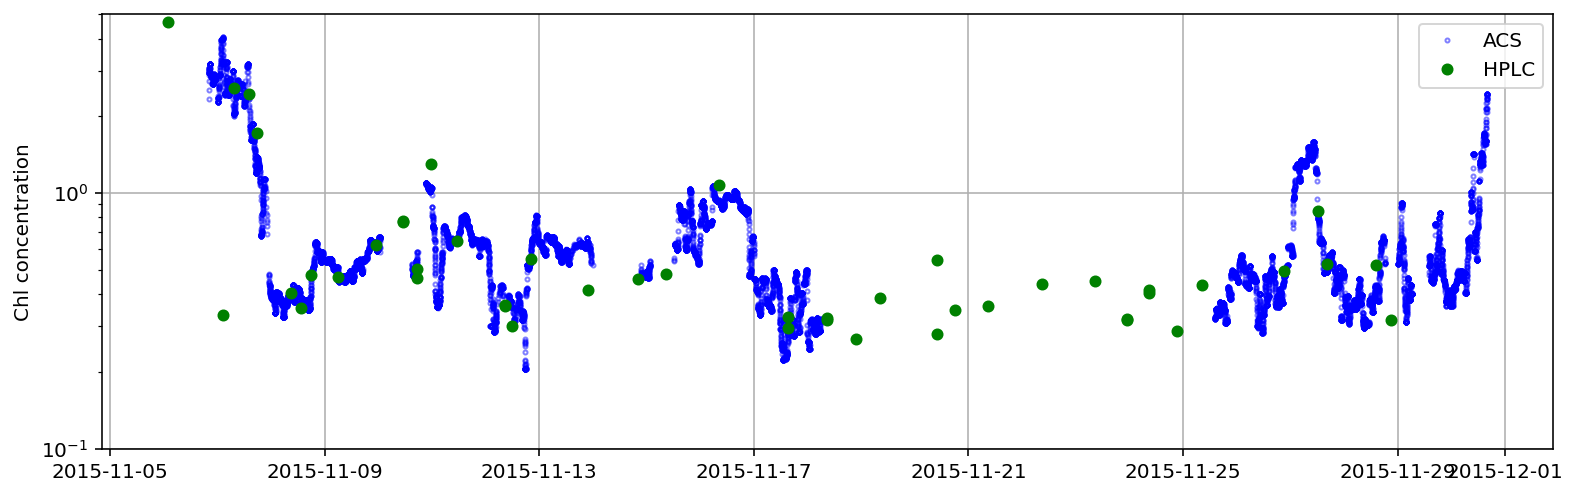

In [8]:
# Test plot of ACS(9) and HPLC Chl prior to match-up
# include emprical adjustment of AC9 chl using AMT
MEDFILT_WIN = 31 # window length of med filter in minutes - note: this assumes data has been binned at 1 minute

#
fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(acs.time, sg.medfilt(acs.acs_chl, kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=2, mfc='none', alpha = 0.5, label='ACS')
ax2.grid('on')
plt.legend()
plt.ylim([1e-1, 5])
plt.ylabel('Chl concentration')

#
print(list(acs.keys()))
ax2.semilogy(acs.hplc_time, acs.hplc_Tot_Chl_a, 'go', ms=5, alpha=1, label='HPLC')#, mfc='none')
# a2.semilogy(df_CTD.index, df_CTD.Tot_Chl_a, 'ko', ms=7, alpha=1, mfc='none', zorder=60)
# ax2.scatter(df_CTD.index, df_CTD.Tot_Chl_a, c=df_CTD.Bottle.values, s=30, alpha=1, zorder=60, cmap = plt.get_cmap('inferno'), vmin=2, vmax=24)
# ax2.semilogy(df_UND.index, df_UND.Tot_Chl_a, 'ks', ms=7, alpha=0.85, mfc='c')
plt.legend()
#########


15187
15187


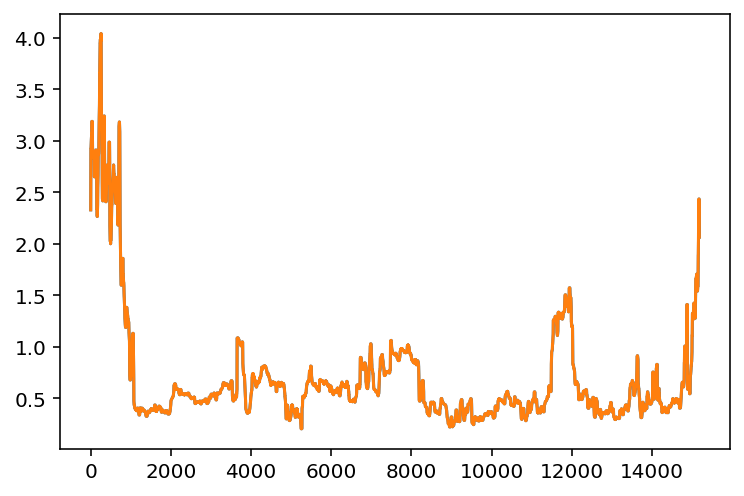

In [9]:
# step x - # median filter
plt.figure()
acs['acs_chl_nomedfilt'] = acs['acs_chl']
acs['acs_chl'].values = sg.medfilt(acs.acs_chl, kernel_size = MEDFILT_WIN) # apply med filter to acx chl and acx chl debiasesd 
plt.plot(acs['acs_chl'].values)

# step y  #filters w.r.t. ap(420) (10th element) being > 0
i2kp = np.where((acs.acs_ap[:,10] > 0)) [0]
iy = xr.DataArray(acs.time[i2kp], dims=['time']) 
acs_y = acs.sel(time = iy)
plt.plot(acs_y['acs_chl'].values)
print(len(acs_y['acs_chl'].values))

#step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs_y.acs_chl[:] > 0)) [0]
iz = xr.DataArray(acs_y.time[i2kp], dims=['time']) 
acs_z = acs_y.sel(time = iz)
print(len(acs_z['acs_chl'].values))

# for NAAMES 1 - data looks to have already had effective QC


In [10]:
acs = []
acs = acs_z # redefine as filtered data structure

In [11]:
acs['acs_chl']

<xarray.DataArray 'acs_chl' (time: 15187)>
array([2.3303356, 2.5156314, 2.7281084, ..., 2.1376097, 2.122544 ,
       2.0656242])
Coordinates:
  * time     (time) datetime64[ns] 2015-11-06T20:11:00 ... 2015-11-30T16:00:00
Attributes:
    units:             mg/m3
    acs_chl_equation:  chla = (acs.ap(:,wv676)-39/65.*acs.ap(:,wv650)-26/65*a...
    acs_chl_comment:   uncalibrated, not-debiased chl estimated from ACS ap

In [12]:
# match-ups #

# creat seriers objects
df_hplc = pd.Series(acs['hplc_Tot_Chl_a'].values,index = acs.hplc_time)
df_acs = pd.Series(acs['acs_chl'].values, index = acs.time)

# filter replicate hplcs
df_hplc = df_hplc.groupby(df_hplc.index).mean().reindex()

#
df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc, 'acs_chl': df_acs},index = df_hplc.index)
df_hplc_acs = df_hplc_acs.interpolate('index',limit=1).reindex(df_hplc_acs.index, method='nearest',tolerance='30min')


In [13]:
print(df_hplc_acs)
# nans in acs_ch are where there are no match-ups

                     Tot_Chl_a   acs_chl
2015-11-06 02:09:00     4.6450       NaN
2015-11-07 02:22:25     0.3320       NaN
2015-11-07 07:20:00     2.5650  2.147791
2015-11-07 14:16:00     2.4310  1.633158
2015-11-07 17:45:00     1.7110  1.374605
2015-11-08 08:52:00     0.4060  0.397651
2015-11-08 13:42:00     0.3530  0.378499
2015-11-08 18:10:00     0.4760  0.415222
2015-11-09 05:49:00     0.4690  0.511005
2015-11-09 22:56:00     0.6270  0.608383
2015-11-10 11:14:00     0.7730  0.556843
2015-11-10 17:12:00     0.4840  0.531841
2015-11-10 23:37:00     1.2990  1.045523
2015-11-11 11:06:00     0.6460  0.826509
2015-11-12 08:30:00     0.3630       NaN
2015-11-12 11:49:00     0.3010  0.355104
2015-11-12 20:14:00     0.5520  0.550743
2015-11-13 21:55:00     0.4150  0.666305
2015-11-14 20:24:00     0.4580       NaN
2015-11-15 08:30:00     0.4800       NaN
2015-11-16 08:30:00     1.0690  0.929899
2015-11-17 15:10:00     0.3115  0.873880
2015-11-18 08:30:00     0.3210       NaN
2015-11-18 21:35

In [14]:
# compute residuals (lin and log space)
rres = df_hplc_acs.acs_chl.values / df_hplc_acs.Tot_Chl_a.values - 1
rres_log = np.log10(df_hplc_acs.acs_chl.values)/np.log10(df_hplc_acs.Tot_Chl_a.values) - 1

delta = np.nanmedian(rres)
delta_log = np.nanmedian(rres_log)
sigma = prcrng(rres)
sigma_log = prcrng(rres_log)
N = np.sum(~np.isnan(rres))
N_log = np.sum(~np.isnan(rres_log))

print('Linear metrics')
print(delta, sigma, N)

print('Log metrics')
print(delta_log, sigma_log, N)


Linear metrics
-0.040669458242458045 0.21554914597721309 22
Log metrics
-0.12159030241637836 0.35597518599995476 22


['hplc_lat', 'hplc_lon', 'hplc_Tot_Chl_a', 'uway_lat', 'uway_lon', 'acs_chl', 'acs_ap', 'acs_chl_nomedfilt']


/tmp/ipykernel_783561/1904596559.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax2.semilogy(df_hplc.index, df_hplc.values, 'go', ms=5, color='green', alpha=1, label='HPLC_all')#, mfc='none')
/tmp/ipykernel_783561/1904596559.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax2.semilogy(df_hplc_acs.index[~np.isnan(rres)==1], df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1], 'go', ms=5, color='red', alpha=1, label='HPLC matches')#, mfc='none')


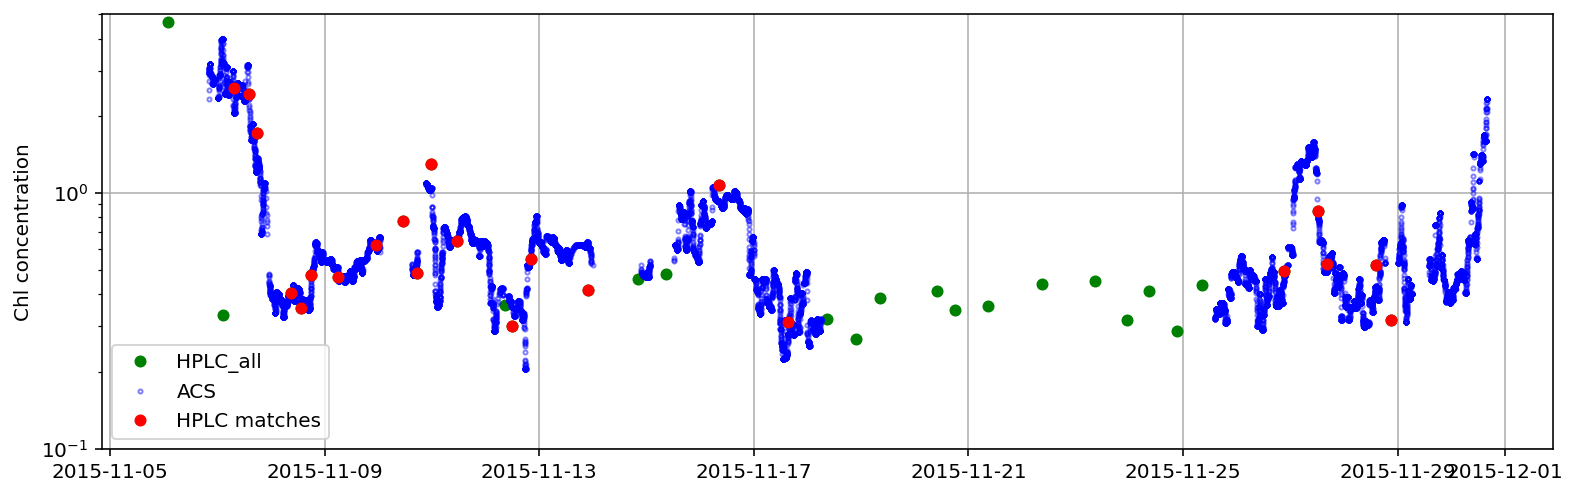

In [15]:
# Test plot of ACS(9) and HPLC Chl post match-up


MEDFILT_WIN = 31 # window length of med filter in minutes - note: this assumes data has been binned at 1 minute. 

#
fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(df_hplc.index, df_hplc.values, 'go', ms=5, color='green', alpha=1, label='HPLC_all')#, mfc='none')
ax2.semilogy(acs.time, sg.medfilt(acs.acs_chl, kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=2, mfc='none', alpha = 0.5, label='ACS')
ax2.grid('on')
plt.legend()
plt.ylim([1e-1, 5])
plt.ylabel('Chl concentration')

print(list(acs.keys()))
ax2.semilogy(df_hplc_acs.index[~np.isnan(rres)==1], df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1], 'go', ms=5, color='red', alpha=1, label='HPLC matches')#, mfc='none')
plt.legend()
#########




[4.645  0.332  2.565  2.431  1.711  0.406  0.353  0.476  0.469  0.627
 0.773  0.484  1.299  0.646  0.363  0.301  0.552  0.415  0.458  0.48
 1.069  0.3115 0.321  0.267  0.386  0.4125 0.348  0.361  0.44   0.451
 0.078  0.3185 0.4115 0.289  0.434  0.494  0.849  0.528  0.522  0.317 ]


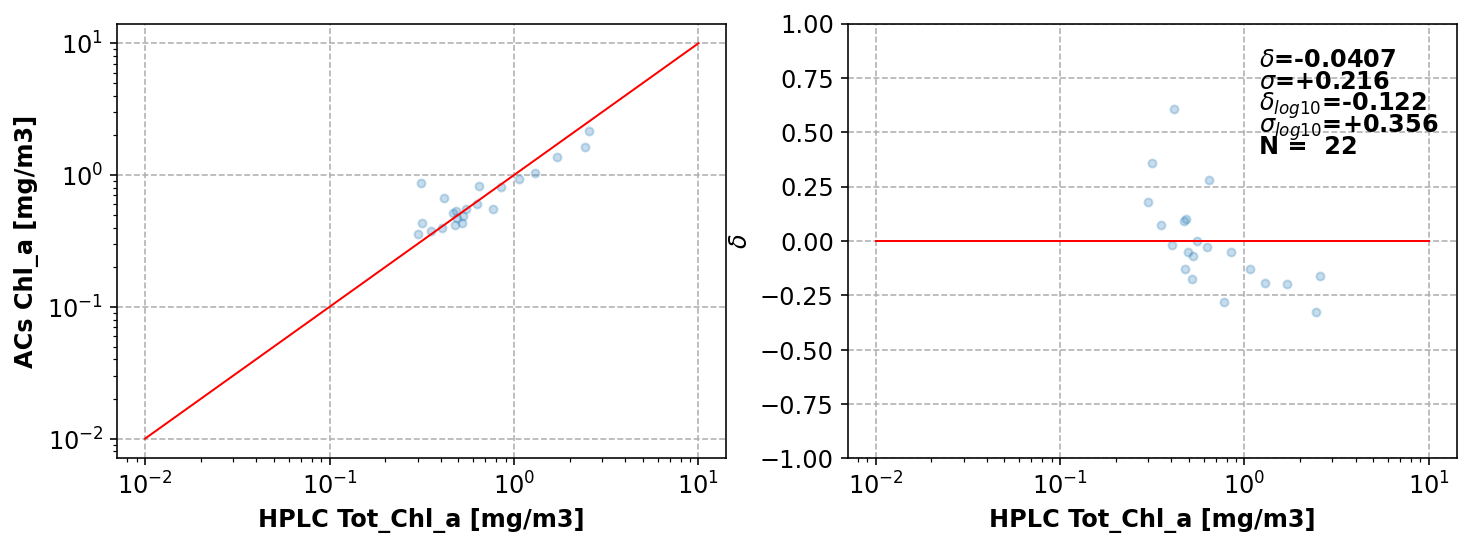

In [16]:
# check time, lat, lon
plt.rcParams.update({'font.size': 12})
    
fig, ax = plt.subplots(1,2, figsize=(12, 4))

ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl.values, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('$\delta$', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(1.2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.7, r'$\sigma$='+f'{sigma:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.6, r'$\delta_{log10}$='+f'{delta_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.5, r'$\sigma_{log10}$='+f'{sigma_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.4, f'N = {N: 0}', fontweight='bold')




print(df_hplc_acs.Tot_Chl_a.values)



(-1.0, 1.0)

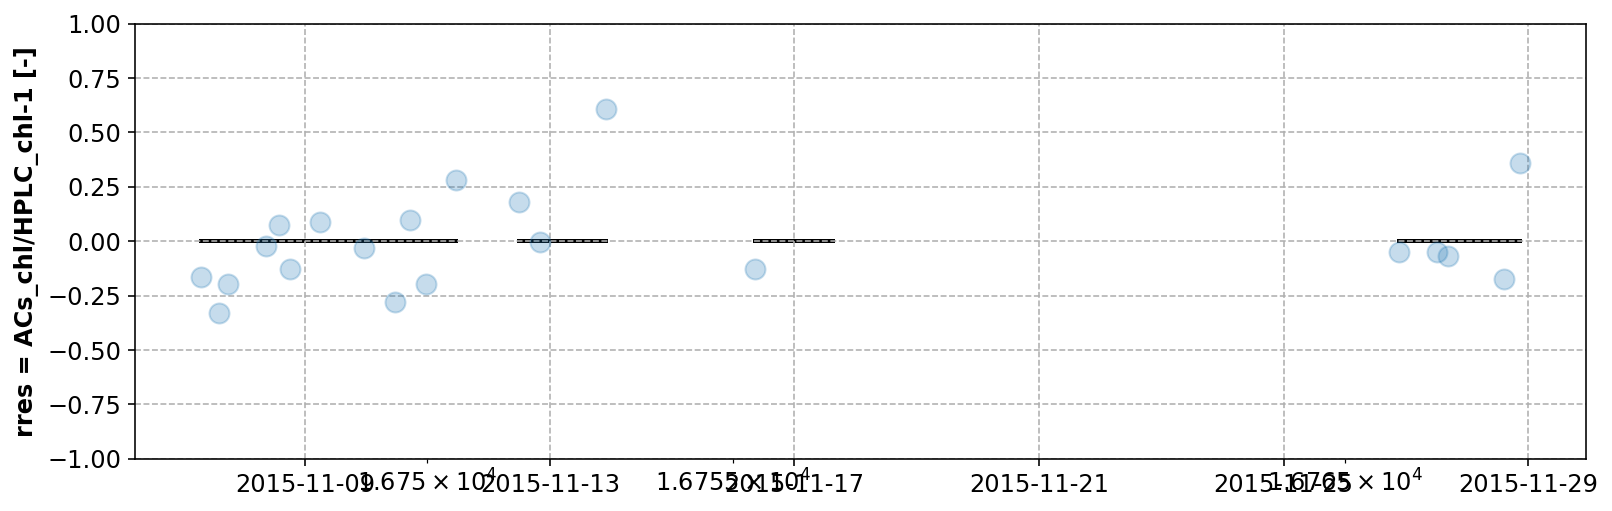

In [17]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.semilogx(df_hplc_acs.index.values, rres, 'o', ms=10, alpha=0.25, zorder=60)
ax.plot(df_hplc_acs.index.values, rres*0, 'k-', lw=2, zorder=1)
ax.set_ylabel('rres = ACs_chl/HPLC_chl-1 [-]', fontweight='bold')
ax.grid('on', ls='--')
ax.set_ylim([-1, 1])

In [18]:
# Apply log transform prior to fitting power-law. Notation follows Brewin 2016. 
import scipy

linear_mod = scipy.stats.linregress(np.log10(0.014*df_hplc_acs.acs_chl.values[~np.isnan(rres)==1]), np.log10(df_hplc_acs.Tot_Chl_a.values[~np.isnan(rres)==1]))

A = np.round(100*linear_mod.intercept)/100
B = np.round(1000*linear_mod.slope)/1000
r_sq = np.round(1000*linear_mod.rvalue**2)/100

r_sq = np.round(1000*linear_mod.rvalue**2)/1000
stderr = np.round(1000*linear_mod.stderr)/1000
interr = np.round(1000*linear_mod.intercept_stderr)/1000

print('A = ' + str(10**A) + ' +/- ' + str(2*10**interr))
print('B = ' + str(B) + ' +/- ' + str(2*stderr))
print('r_sq = ' + str(r_sq))

A = 120.22644346174131 +/- 3.7934118424222927
B = 1.116 +/- 0.27
r_sq = 0.772


In [19]:
# de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)

acs['acs_chl_debiased_nomedfilt'] = acs.acs_chl_nomedfilt*(1-delta)
acs['acs_chl_debiased_nomedfilt'] = acs.acs_chl_nomedfilt*(1-delta)
# acs_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan],
#                              'lon [degE]': acs.uway_lon[i2f][innan],
#                             'acs_chl_debiased [mg_m3]': acs.acs_chl_debiased[i2f][innan]
#                           }  ,
# index = acs.time.values[i2f][innan])

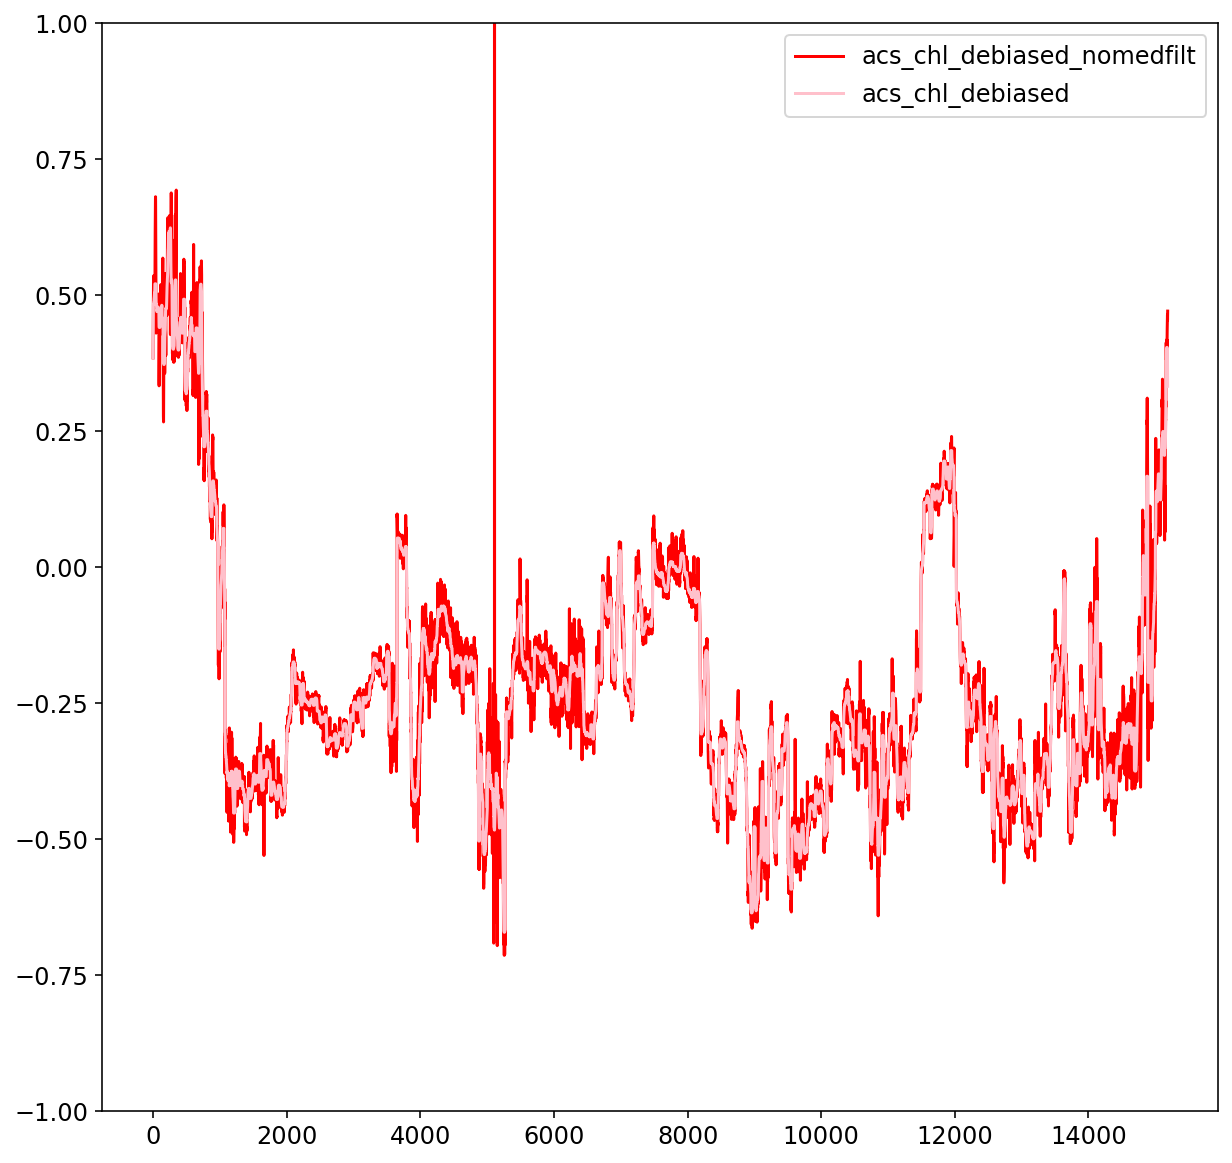

In [25]:
plt.figure(figsize=(10,10))
plt.plot(np.log10(acs['acs_chl_debiased_nomedfilt'].values), color='red', label ='acs_chl_debiased_nomedfilt')
plt.plot(np.log10(acs['acs_chl_debiased'].values), color='pink', label ='acs_chl_debiased')
#plt.plot(np.log10(acs['acs_chl_nomedfilt'].values), color='blue', label ='acs_chl_nomedfilt')
#plt.plot(np.log10(acs['acs_chl'].values), color='green', label ='acs_chl')
plt.ylim(-1,1)
plt.legend()

In [26]:
# add attributes to acs_chl_debiased #
acs.acs_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
acs.acs_chl_debiased.attrs["delta"] = delta
acs.acs_chl_debiased.attrs["sigma"] = sigma
acs.acs_chl_debiased.attrs["units"] = "mg/m3"
acs.acs_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acs_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1].values  # filter nans
acs.acs_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["acs_chl"] = df_hplc_acs[~np.isnan(rres)==1].acs_chl.values # filter nans
acs.acs_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acs_chl_debiased.attrs["match_up_dates"] = df_hplc_acs[~np.isnan(rres)==1].index.format()

In [27]:
# add attributes to acs_chl_debiased #
acs.acs_chl_debiased_nomedfilt.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
acs.acs_chl_debiased_nomedfilt.attrs["delta"] = delta
acs.acs_chl_debiased_nomedfilt.attrs["sigma"] = sigma
acs.acs_chl_debiased_nomedfilt.attrs["units"] = "mg/m3"
acs.acs_chl_debiased_nomedfilt.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acs_chl_debiased_nomedfilt.attrs["HPLC_Tot_chla"] = df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1].values  # filter nans
acs.acs_chl_debiased_nomedfilt.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acs_chl_debiased_nomedfilt.attrs["acs_chl"] = df_hplc_acs[~np.isnan(rres)==1].acs_chl.values # filter nans
acs.acs_chl_debiased_nomedfilt.attrs["acs_chl_units"] = "mg/m3"
acs.acs_chl_debiased_nomedfilt.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acs_chl_debiased_nomedfilt.attrs["match_up_dates"] = df_hplc_acs[~np.isnan(rres)==1].index.format()

In [28]:
print(acs.acs_chl_debiased)
len(acs.acs_chl_debiased.attrs["match_up_dates"])
len(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"])

<xarray.DataArray 'acs_chl_debiased' (time: 15187)>
array([2.42510909, 2.61794077, 2.83905909, ..., 2.22454513, 2.20886671,
       2.14963202])
Coordinates:
  * time     (time) datetime64[ns] 2015-11-06T20:11:00 ... 2015-11-30T16:00:00
Attributes:
    debiasing_equation:   acs.acs_chl_debiased = acs.acs_chl*(1-delta)
    delta:                -0.040669458242458045
    sigma:                0.21554914597721309
    units:                mg/m3
    comments:             delta=np.nanmedian(rres), sigma=prcrng(rres), rres=...
    HPLC_Tot_chla:        [2.565  2.431  1.711  0.406  0.353  0.476  0.469  0...
    HPLC_Tot_chla_units:  mg/m3
    acs_chl:              [2.1477911  1.6331585  1.3746051  0.3976505  0.3784...
    acs_chl_units:        mg/m3
    processed_on:         2024-02-29 10:21:04.567307
    match_up_dates:       ['2015-11-07 07:20:00', '2015-11-07 14:16:00', '201...


22

In [29]:
print('max/min conc range for results table')
print(np.min(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"]))
print(np.max(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"])) # quote min max of match-ups 

max/min conc range for results table
0.301
2.565


In [30]:

# save updated NetCDF file
dir_acs_out = '/data/datasets/cruise_data/active/ACS_Chl/Glob_OC_matchups/Debiased_nc/'
acs.to_netcdf(dir_acs_out + fn_acs[:-3] + '_with_debiased_chl.nc')
acs.close()
